In [1]:
!pip install qutip

Defaulting to user installation because normal site-packages is not writeable


<h3> Usefull Python libraries </h3>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import qutip as qt
import pandas as pd
from tqdm.notebook import tqdm
from itertools import product
from scipy.stats import uniform_direction
from scipy.optimize import curve_fit
resol = 300

<h3> Functions from the gap_tools_ed library </h3>

In [2]:
def hamiltonian(J,h,gamma,timesTab,tp,up):
    """
    Compute the Hamiltonian of the system.

    Parameters
    ----------
    J : numpy array
        The coupling matrix.
    h : numpy array
        The local fields.
    gamma : float
        Stenght of the transverse field.
    timesTab : numpy array
        Discretization of the annealing period [0,T]
    tp : numpy array
        Points where the control function is known
    uTab : numpy array
        Values of the control function at points tp

    Returns
    -------
    H : qutip.qobj
        The Hamiltonian of the system for a given value u of the control function

    """
    N = len(h)
    # Setup operators for individual qubits
    sx_list, sy_list, sz_list = [], [], []
    for i in range(N):
        op_list = [qt.qeye(2)] * N
        op_list[i] = qt.sigmax()
        sx_list.append(qt.tensor(op_list))
        op_list[i] = qt.sigmay()
        sy_list.append(qt.tensor(op_list))
        op_list[i] = qt.sigmaz()
        sz_list.append(qt.tensor(op_list))

    #Problem Hamiltonian
    H0 = 0
    for i in range(N):
        H0 -=  h[i] * sz_list[i]
    for i in range(N):
        for j in range(N):
            H0 -=  J[i,j] * sz_list[i] * sz_list[j]

    #Control Hamiltonian
    H1 = 0
    for i in range(N):
        H1 -= sx_list[i]
    H1 = gamma * H1

    #time-dependant coefficients
    def A(t):
        return 1 - np.interp(t,tp,up) #interpolation of the control function

    def B(t):
        return np.interp(t,tp,up) #interpolation of the control function

    A_list = A(timesTab)
    B_list = B(timesTab)

    #Hamiltonian
    H = qt.QobjEvo([[H0,A_list], [H1,B_list]],tlist=timesTab)

    return H

def annealing_time(uTab, gapTab, epsilon):
    """
    Compute the annealing time given the gap of the system at various times.

    Parameters
    ----------
    uTab : numpy array
        Discretization of the control function
    gapTab : numpy array
        The gap of the system at control parameters u contained in uTab.
    epsilon : float
        The target precision.

    Returns
    -------
    Tint : float
        The annealing time evaluated with an integral (non linear control function).
    Tlin : float
        The annealing time required for a linear control function.
    """

    gapMin = np.min(gapTab)

    if gapMin < 1e-10:
        print("The gap vanishes at some point. The annealing time is infinite.")
        return np.inf, np.inf

    Tlin = 1/epsilon * 1/gapMin**2

    Tint = -1/epsilon * np.trapz(1/gapTab**2, uTab)

    return Tint, Tlin

def evolve_state(H, timesTab, psi0):
    """
    Compute the state of the system at different times.

    Parameters
    ----------
    H : qutip.qobj
        The Hamiltonian of the system.

    timesTab : numpy array
        Discretization of the time interval

    psi0 : qutip.qobj
        The initial state of the system.

    Returns
    -------
    overlapTab : numpy array
        The overlap between the current state and the targeted state at different times.

    """
    N = int(np.log2(len(psi0.full())))

    # Setup operators for individual qubits
    sx_list, sy_list, sz_list = [], [], []
    for i in range(N):
        op_list = [qt.qeye(2)] * N
        op_list[i] = qt.sigmax()
        sx_list.append(qt.tensor(op_list))
        op_list[i] = qt.sigmay()
        sy_list.append(qt.tensor(op_list))
        op_list[i] = qt.sigmaz()
        sz_list.append(qt.tensor(op_list))

    #Problem Hamiltonian
    H0 = H(timesTab[-1])
    #Eigenbasis of the problem Hamiltonian
    projectors_list = []
    states_list = []
    for i in range(2**N):
        eigenstate = H0.eigenstates()[1][i]
        states_list.append(eigenstate)
        projectors_list.append(eigenstate.proj())

    exp_values_list = projectors_list + sz_list


    try:
        result = qt.sesolve(H, psi0, timesTab, exp_values_list, options=qt.Options(nsteps=20000))

        expectation_values = result.expect
        proba_coef = expectation_values[0:2**N]
        sigma_z_exp = expectation_values[2**N:]

    except:
        print("Error : QuTip has not converged")
        proba_coef = [np.nan*np.zeros(len(timesTab)) for i in range(2**N)]
        sigma_z_exp = [np.nan*np.zeros(len(timesTab)) for i in range(N)]

    return proba_coef, sigma_z_exp, states_list

def initialize_parameters(C, b0, w, gaussianNoise, lbda, print_params=False):
    """
    Parameters
    ----------
    C : numpy array
        The code words of the sequences. The code words are the columns of the matrix and are assumed to be normalized.
    b0 : numpy array
        The initial activity pattern.
    w : numpy array
        The channel coefficients.
    gaussianNoise : numpy array
        The gaussian noise at the BS
    lbda : float
        The regularization parameter.
    print_params : bool, optional
        Print the generated J_ij and h_i. The default is False.

    Returns
    -------
    J : numpy array
        The coupling matrix.
    h : numpy array
        The local fields.

    """
    N = C.shape[1] #number of nodes
    M = C.shape[0] #size of the sequences

    codesCopy = C.copy()
    #Take into account the channel coeffcients
    for i in range(N):
        codesCopy[:,i] = w[i]*codesCopy[:,i]

    #received signal
    y = codesCopy.dot(b0.T) + gaussianNoise #received signal
    power = np.linalg.norm(y)**2

    #defining the couplings J_ij
    J = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            J[i,j] = - 1/2*codesCopy[:,i].dot(codesCopy[:,j])

    #defining the local fields h_i
    h = np.zeros(N)
    for i in range(N):
        h[i] = -1*np.dot(codesCopy[:,i],y)
        for j in range(N):
            h[i] += 1/2 * codesCopy[:,i].dot(codesCopy[:,j])
        h[i] += lbda/2

    if print_params:
        print("Received power : ",power)
        print("Number of nodes : ",N)
        print("Size of the sequences: ",M)
        print("Active users: ",b0)
        print("-----------------")
        print("Local fields : \n",h)
        print("-----------------")
        print("Couplings matrix : \n",J)

    return J,h,power

def get_control_function(uTab, gap_squared, epsilon):
    """
    Compute the control function given the gap of the system at various times.

    Parameters
    ----------
    uTab : numpy array
        Discretization of the control function
    gap_squared : numpy array
        The gap Delta^2 of the system at control parameters u contained in uTab.
    epsilon : float
        The target precision.

    Returns
    -------
    timesTab : numpy array
        The times such that u(t[i]) = uTab[i] for i in range(len(tTab)).

    """

    gapMin = np.min(gap_squared)
    nbPts = len(uTab)
    timesTab = np.zeros(nbPts)


    if gapMin < 1e-10:
        print("The gap vanishes at some point. The annealing time is infinite.")
        return np.nan*timesTab

    timesTab[0] = 0

    for i in range(1,nbPts):
        timesTab[i] = timesTab[i-1] + 1/epsilon * (uTab[i-1]-uTab[i])/gap_squared[i]

    return timesTab

def spectrum(H, timesTab, progressBar = True):
    """
    Compute the spectrum of the system.

    Parameters
    ----------
    H : qutip.qobj
        The Hamiltonian of the system.
    timesTab : numpy array
        Times at which we know the Hamiltonian
    progressBar : bool, optional
        If True, display a progress bar. The default is True.


    Returns
    -------
    spectrum : numpy array
        The spectrum of the system at control parameters u contained in timesTab

    """
    spectrum = np.zeros((len(timesTab),len(H(0).eigenenergies())))
    for i in tqdm(range(len(timesTab)),disable = not progressBar):
        spectrum[i] = H(timesTab[i]).eigenenergies()

    return spectrum

def gap(H, timesTab, progressBar = True):
    """
    Compute the gap of the system.

    Parameters
    ----------
    H : qutip.qobj
        The Hamiltonian of the system.
    progressBar : bool, optional
        If True, display a progress bar. The default is True.
    Returns
    -------
    gap : numpy array
        The gap of the system at control parameters u contained in H.tlist .

    """

    gap = np.zeros(len(timesTab))
    for i in tqdm(range(len(timesTab)),disable = not progressBar):
        energiesTab = H(timesTab[i]).eigenenergies()
        gap[i] = energiesTab[1] - energiesTab[0]

    return gap

<h1> Generate Hamiltonian </h1>

The function generate_signal returns the matrix of the received signal Y given:
- An activity pattern
- A pilot matrix
- A level of AWGN at the AP
- A number of antenna

The function get_couplings returns the couplings $J_{ij}$ and the local fields $b_i$ allowing to build the Ising Hamiltonian associated to the problem instance $(P, Y)$. Recall that they are given by:

$$\begin{dcases}
    b_i &= - \text{Tr}\left(\bm{p}_i \bm{p}_i^H \hat{\bm{\Sigma}}_Y\right) + \frac{1}{2} \sum_{j=1}^N |\bm{p}_i^H \bm{p}_j|^2\\
    J_{ij} &= -\frac{1}{2} |\bm{p}_i^H \bm{p}_j|^2
    \end{dcases}$$

In [3]:
def generate_signal(alpha, P, xi, K):
    """
    Generates the signal matrix Y given the required parameters.

    Parameters
    ----------
    alpha : numpy array
        Activity pattern
    P : numpy array
        Pilot matrix
    xi : float
        Level of noise at the AP
    K : int
        Number of antennas

    Returns
    -------
    Y : numpy array
        Signal matrix
    """

    M, N = P.shape
    Z = np.random.normal(0, xi, (M,K))
    H_tilde = np.random.normal(0, 1, (N,K))

    alpha_diag = np.diag(alpha)
    signal = P @ alpha_diag @ H_tilde + Z

    return signal

def get_couplings(Y, P):
    """
    Computes the couplings J and b for the Ising model.

    Parameters
    ----------
    Y : numpy array
        Signal matrix
    P : numpy array
        Pilot matrix

    Returns
    -------
    J : numpy array
        Couplings
    b : numpy array
        Local fields
    """

    M,K = Y.shape
    N = P.shape[1]

    J = np.zeros((N,N))
    b = np.zeros(N)

    projectors_list = np.zeros((N,M,M))
    for i in range(N):
        p_vector = np.matrix(P[:,i]).T
        projectors_list[i] = p_vector @ p_vector.T

    sampled_cov = 1/K * Y @ np.conjugate(Y.T)

    for i in range(N):
        for j in range(i+1, N):
            J[i,j] = -1/2 * np.trace(projectors_list[i] @ projectors_list[j])

    for i in range(N):
        b[i] = - np.trace(projectors_list[i] @ sampled_cov)
        for j in range(N):
           b[i] += 1/2* np.trace(projectors_list[i] @ projectors_list[j])

    return J, b

<h1> Test the functions </h1>

<h3> Generate a problem instance </h3>

In [66]:
N = 5
M = 4
K = 100
xi = 0 #thermal noise at the BS

P = np.zeros((M,N))
for i in range(N):
    P[:,i] = uniform_direction.rvs(M)

alpha = np.array([1,0,0,0,0])
Y = generate_signal(alpha, P, xi, K)

print("Received signal:")
print(f"shape: {np.shape(Y)}")
#print(Y)
print("-----------------")
J, b = get_couplings(Y, P)
print("Couplings:")
print(J)
print("Fields:")
print(b)

Received signal:
shape: (4, 100)
-----------------
Couplings:
[[ 0.         -0.06055431 -0.0102317  -0.00792157 -0.31973565]
 [ 0.          0.         -0.2475429  -0.21427865 -0.26470742]
 [ 0.          0.          0.         -0.00834268 -0.24683457]
 [ 0.          0.          0.          0.         -0.02866051]
 [ 0.          0.          0.          0.          0.        ]]
Fields:
[-0.13485108  1.16194243  0.99180715  0.74283278  0.69917609]


<h3> Fix parameters </h3>

In [5]:
nb_pts_gap = 20 #number of points for the gap computation
nb_pts_time = 30 #number of points for resolution of the time dependant Schrodinger's equation
epsilon = 0.1 #precision level for the control function
gamma = 1 #strength of the transverse field, irrelevant for us

<h3> Compute the gap at some points </h3>

In [6]:
#use the control function as affine parameter
up = np.linspace(1,0,nb_pts_gap)
tp_linear = np.linspace(0,1,nb_pts_gap)
times_tab_linear = np.linspace(0,1,nb_pts_gap)

Hlinear = hamiltonian(J,b,gamma,times_tab_linear, tp_linear, up)

#get the spectrum
spectrum_tab = spectrum(Hlinear, times_tab_linear)

#get the gap
gap_tab = spectrum_tab[:,1] - spectrum_tab[:,0]
squared_gap = gap_tab**2

  0%|          | 0/20 [00:00<?, ?it/s]

Plot the result

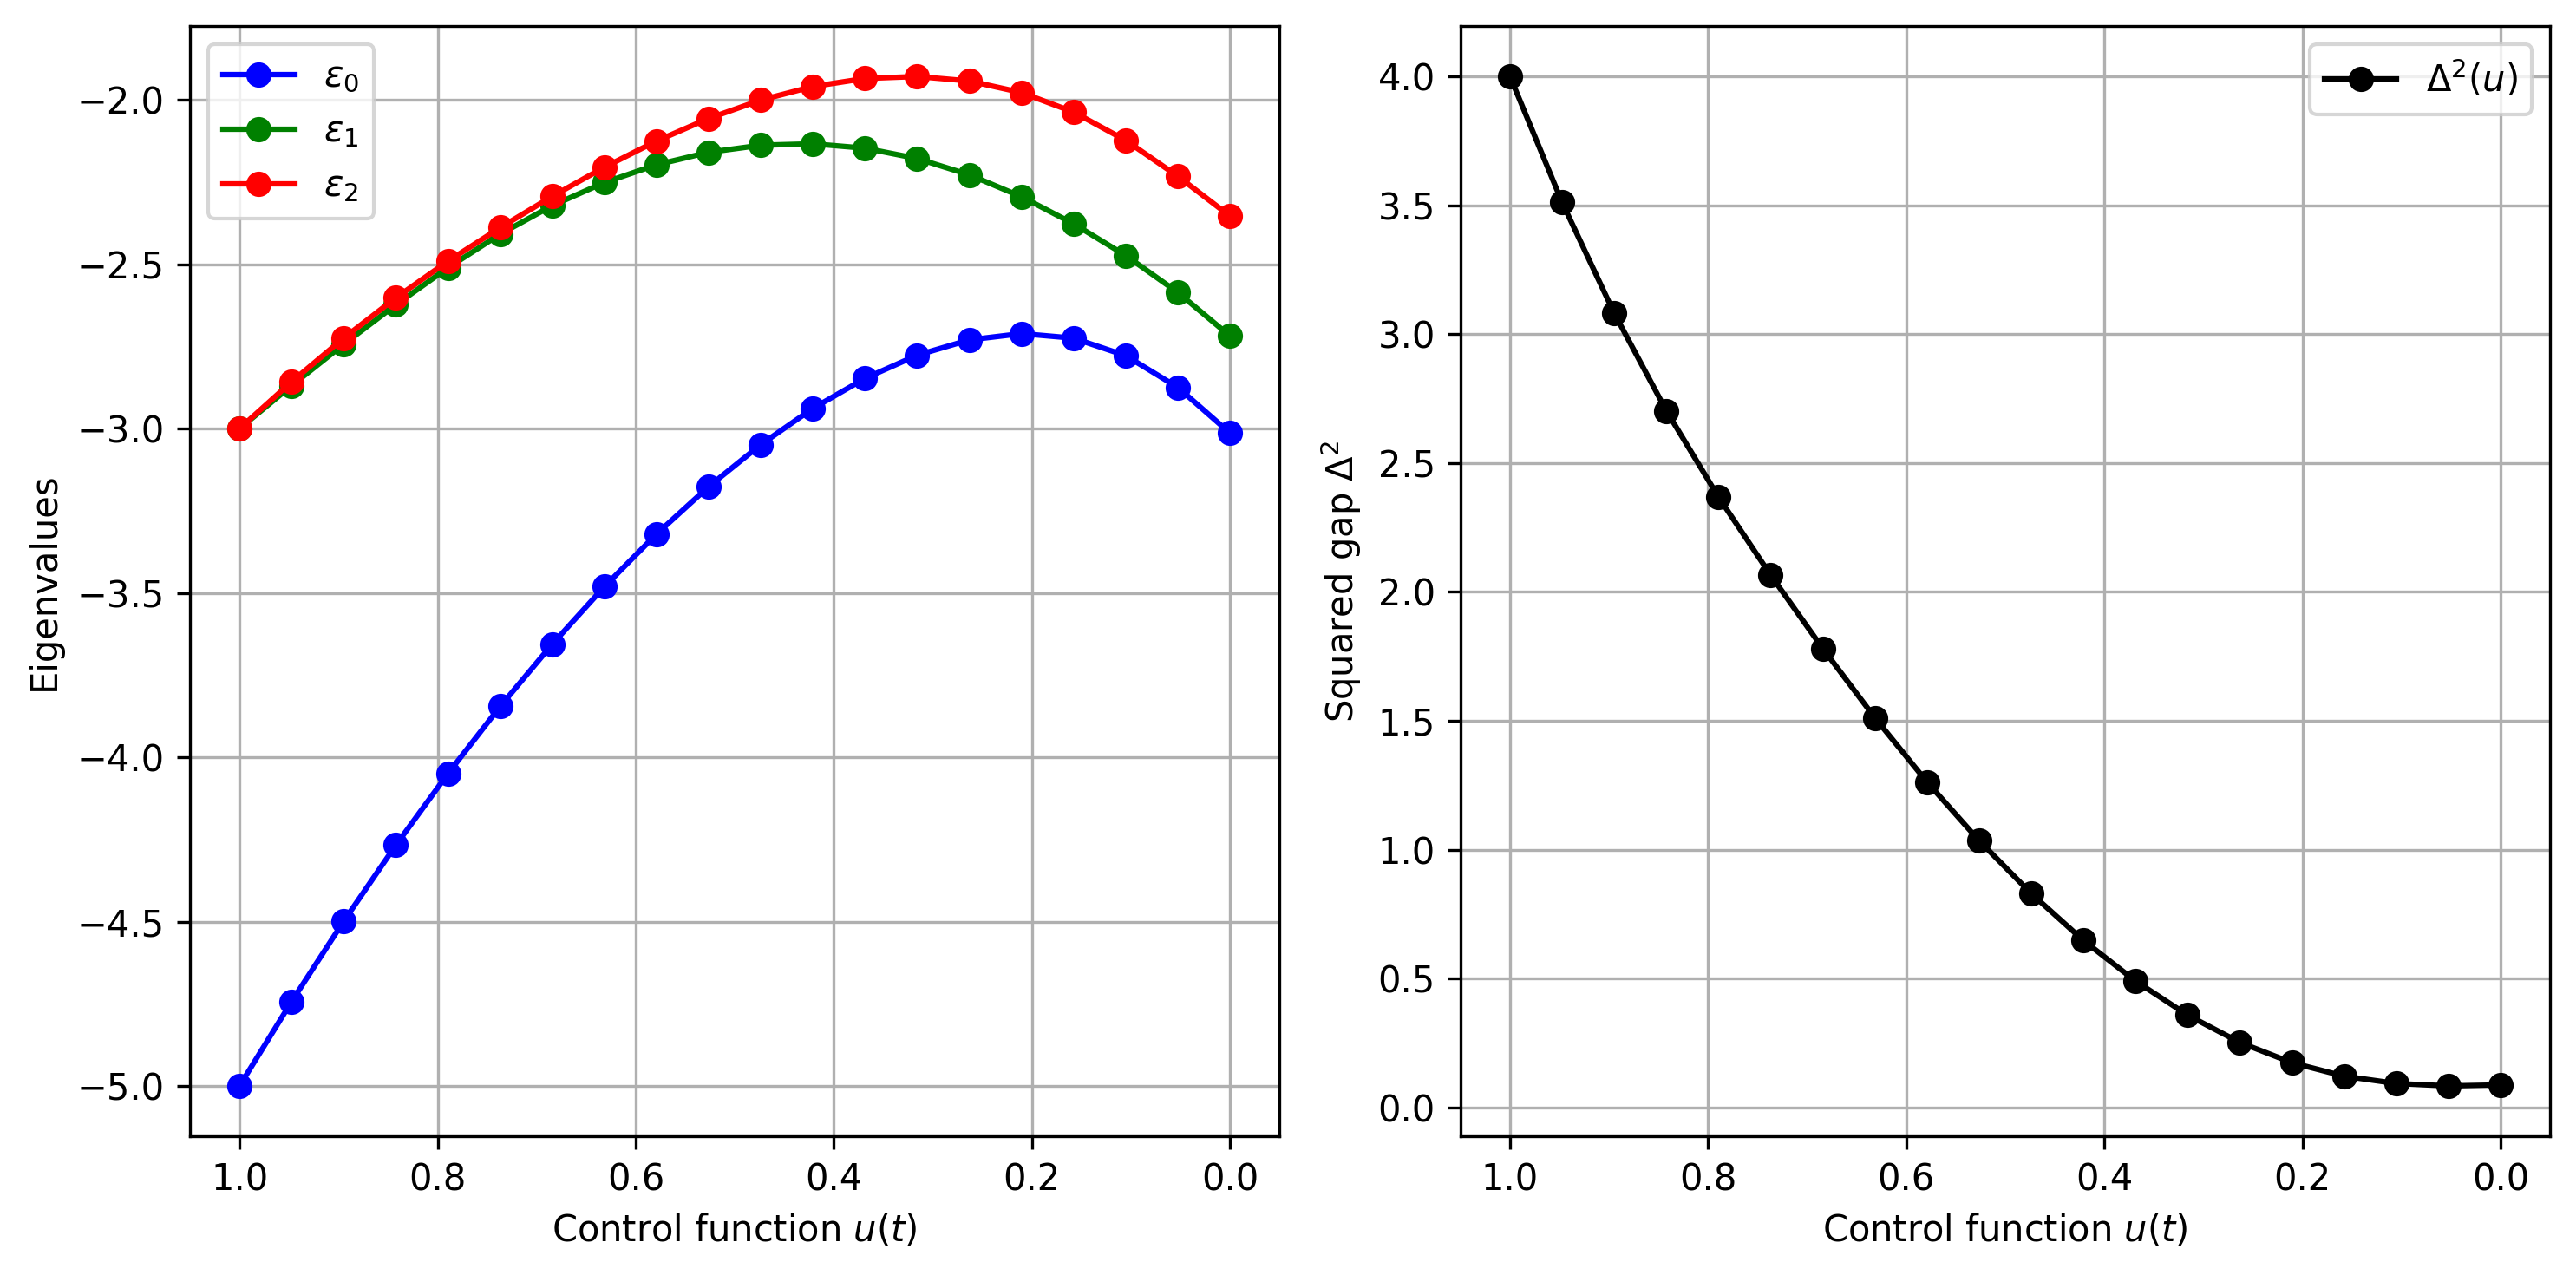

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=resol)

ax[0].plot(up, spectrum_tab[:,0], marker='o', label="$\\varepsilon_0$", color="blue")
ax[0].plot(up, spectrum_tab[:,1], marker='o', label="$\\varepsilon_1$", color="green")
ax[0].plot(up, spectrum_tab[:,2], marker='o', label="$\\varepsilon_2$", color="red")
ax[0].set_xlabel("Control function $u(t)$")
ax[0].set_ylabel("Eigenvalues")
ax[0].invert_xaxis()
ax[0].legend()
ax[0].grid()

ax[1].plot(up, squared_gap, marker='o', label="$\\Delta^2(u)$", color="black")
ax[1].set_xlabel("Control function $u(t)$")
ax[1].set_ylabel("Squared gap $\\Delta^2$")
ax[1].invert_xaxis()
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

<h3> Deduce the control function </h3>

This cell computes the control function and plots the result

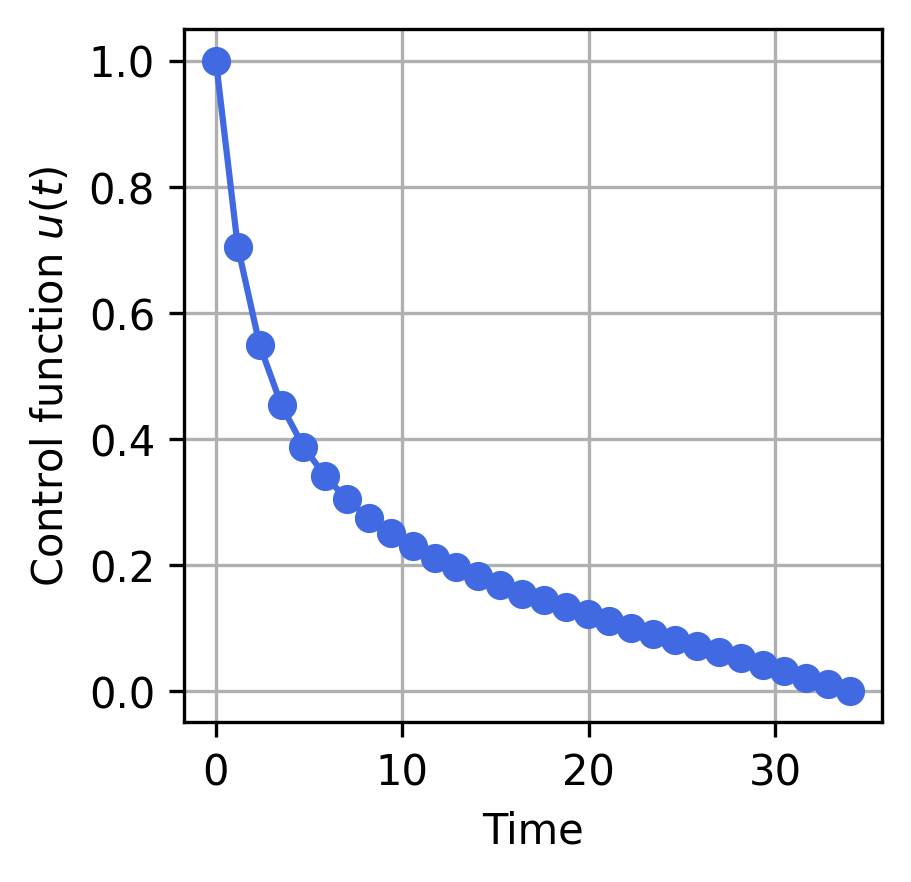

In [8]:
###Control function
tp = get_control_function(up, squared_gap, epsilon)

def control_fct(t):
    return np.interp(t, tp, up)

times_tab = np.linspace(0,tp[-1],nb_pts_time)

plt.figure(figsize=(3,3), dpi=resol)
plt.plot(times_tab, control_fct(times_tab), marker='o', color="royalblue")
plt.xlabel("Time")
plt.ylabel("Control function $u(t)$")
plt.grid()
plt.show()

<h3> Solve the Schrodinger's equation </h3>

Now that the control function is known, we can solve the time dependant Schrodinger's equation:

$$ i \hbar \partial_t \ket{\Psi(t)} = H(u(t)) \ket{\Psi(t)} $$

In [67]:
##initial state
state_list = [(qt.basis(2, 0) + qt.basis(2,1))/np.sqrt(2)]*N
psi0 = qt.tensor(state_list)

#Hamiltonian properly defined with the control function
Hscheduled = hamiltonian(J,b,gamma,times_tab, tp, up)

proba_coef, sigma_z_exp, basis = evolve_state(Hscheduled, times_tab, psi0)

#treat the data
mean_sigmaz = np.zeros((N, nb_pts_time))
for i in range(N):
    mean_sigmaz[i] = np.real(sigma_z_exp[i])

overlap = proba_coef[0]

/home/fabian/.local/lib/python3.10/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


Evolution of the overlap between the current state and the target state

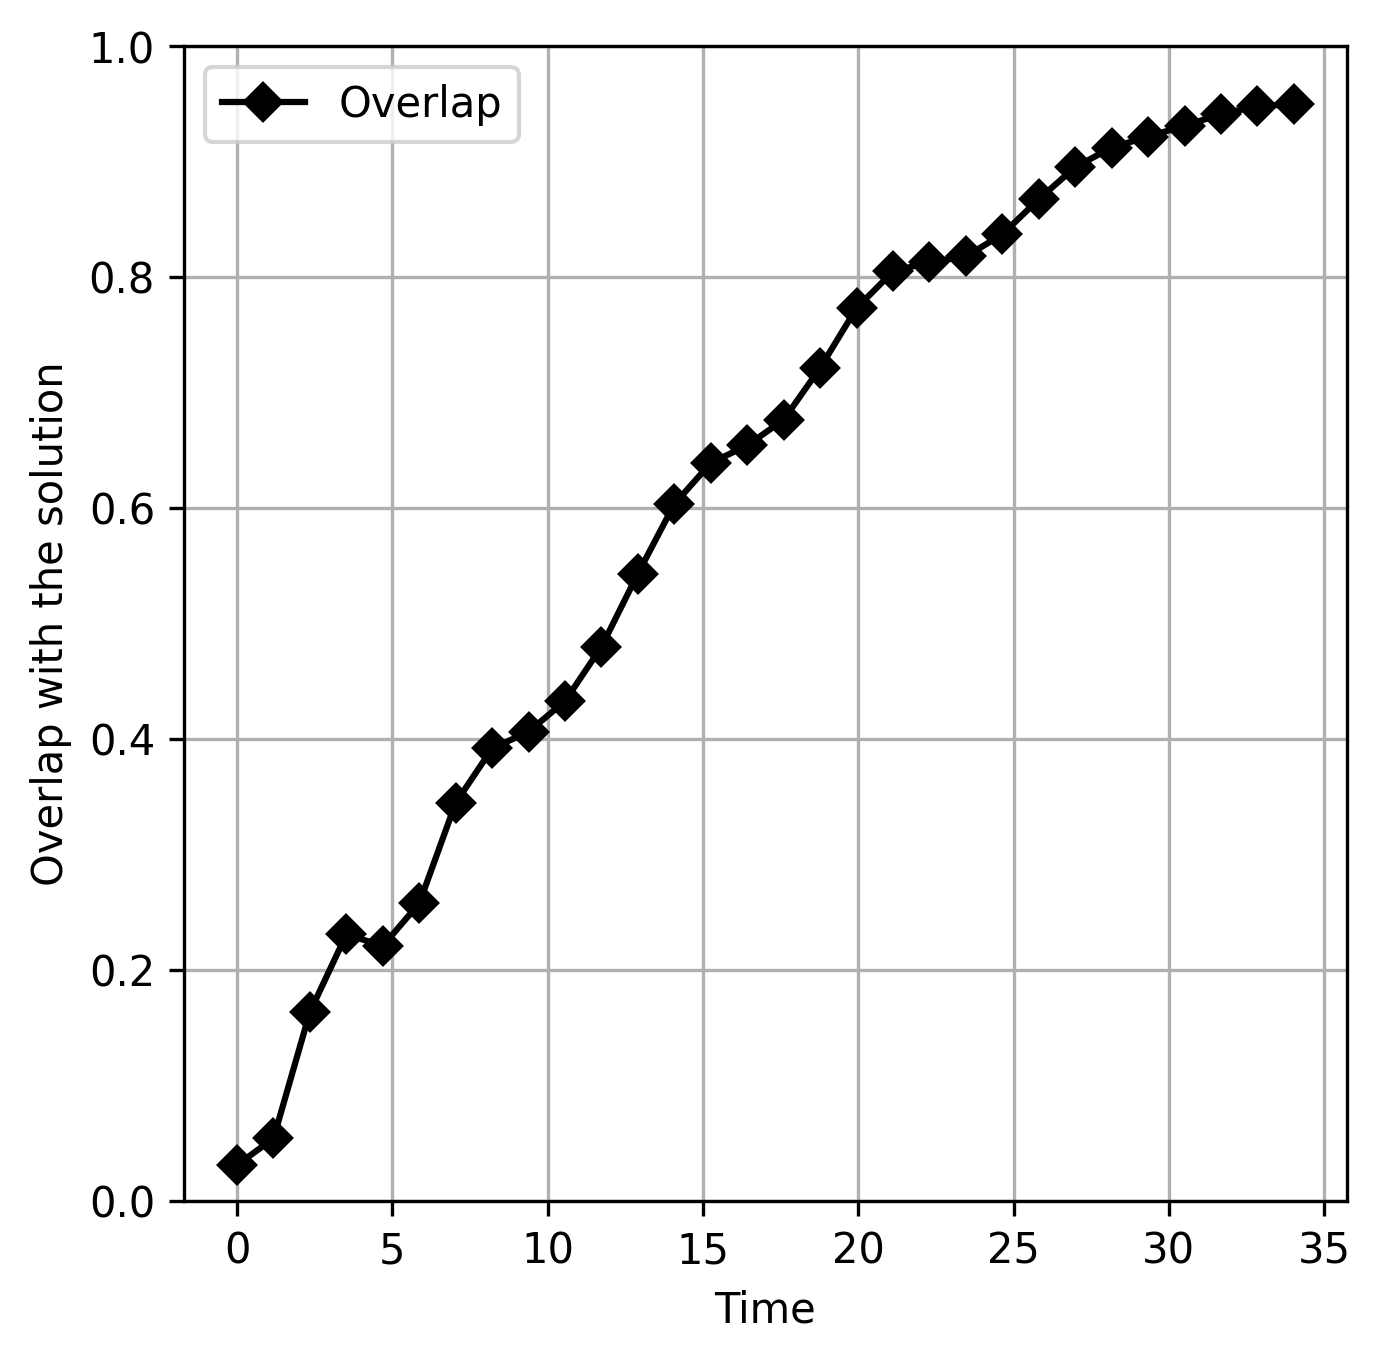

In [10]:
plt.figure(figsize=(5,5), dpi=resol)
plt.plot(times_tab, overlap, marker="D", label="Overlap", color="black")
plt.xlabel("Time")
plt.ylabel("Overlap with the solution")
plt.ylim(0,1)
plt.legend(loc="upper left")
plt.grid()
plt.show()

<h3> Final distribution </h3>

Finally, we can check the amplitudes in the final states

Ground state of the final Hamiltonian: 10000
The initial activity pattern is [1 0 0 0 0]


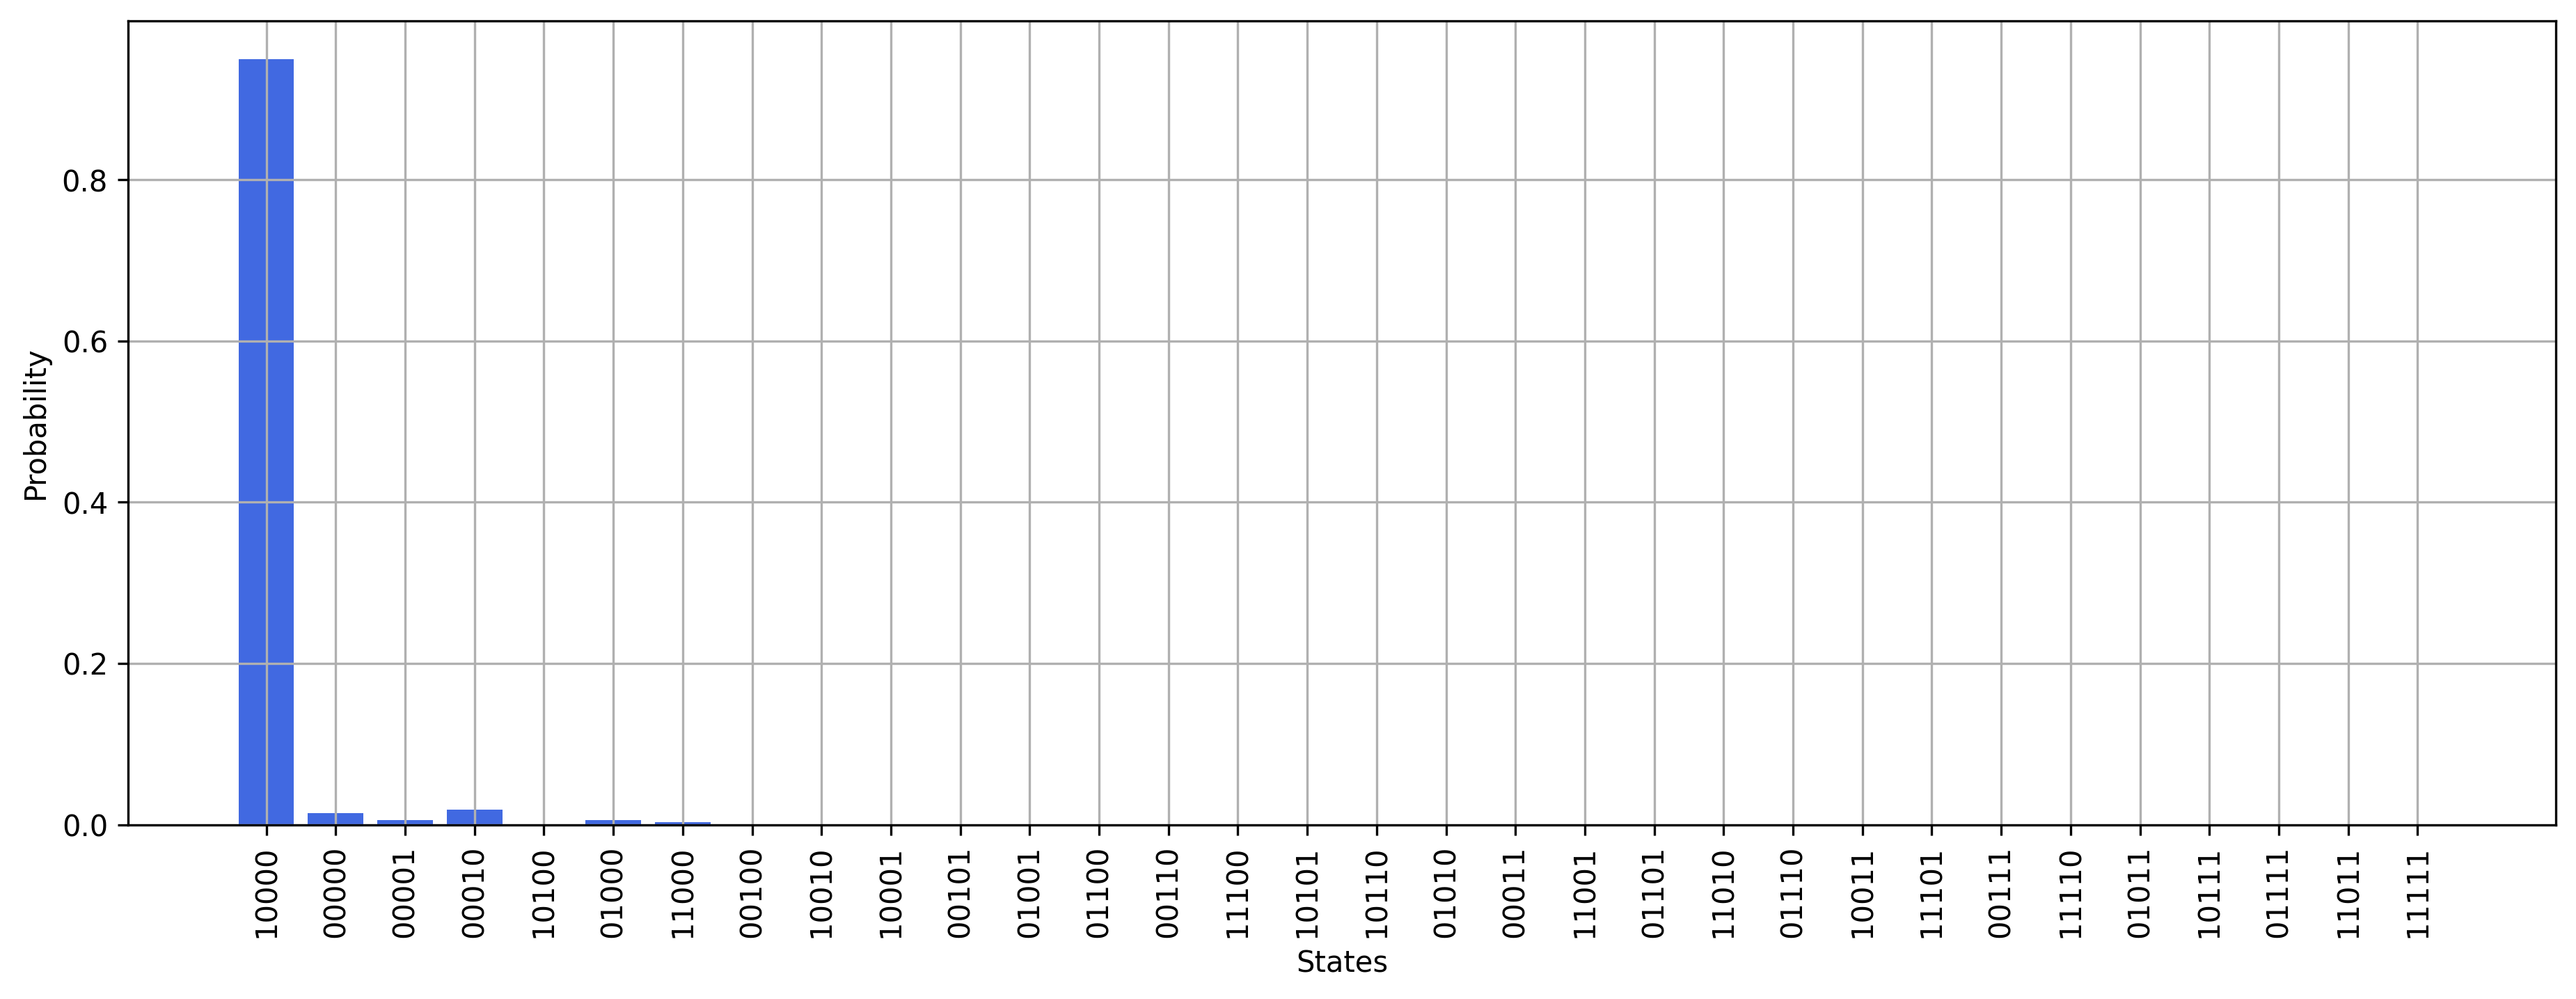

0.9999999999999998


In [11]:
#list of labels
states_string = list(product([0,1], repeat = N))
states_string = ["".join([str(i) for i in state]) for state in states_string]
xlabels = states_string.copy()
coef_to_plot = np.zeros(2**N)

for i in range(2**N):
    current_state = np.real(basis[i].full().reshape(2**N))
    index_state = np.where(np.abs(current_state) > 0.99)[0][0]
    xlabels[i] = states_string[index_state]
    coef_to_plot[i] = proba_coef[i][-1]

#get the GS of the final Hamiltonian
ground_state = Hlinear(1).groundstate()[1]
idx = np.argmax(np.abs(ground_state.full()))
gs_string = states_string[idx]
print("Ground state of the final Hamiltonian:", gs_string)
print("The initial activity pattern is" , alpha)


plt.figure(figsize=(15, 5), dpi=resol)
plt.bar(xlabels, coef_to_plot, color="royalblue")
plt.xticks(rotation=90)
plt.xlabel("States")
plt.ylabel("Probability")
plt.grid()
plt.show()

print(np.sum(coef_to_plot))